<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/Assgn1_Q2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install ipympl

# **Importing Libraries**

In [2]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
from google.colab import output
output.enable_custom_widget_manager()

# **Creating the gaussian data with scale factor = 3**

Mean vectors (mu):
[[ 3.46410162  3.46410162  3.46410162]
 [ 6.92820323  6.92820323  6.92820323]
 [10.39230485 10.39230485 10.39230485]
 [13.85640646 13.85640646 13.85640646]]

Distances between means:
Distance between Class 1 and Class 2: 5.999999999999999
Distance between Class 1 and Class 3: 12.000000000000002
Distance between Class 1 and Class 4: 18.0
Distance between Class 2 and Class 3: 6.000000000000001
Distance between Class 2 and Class 4: 11.999999999999998
Distance between Class 3 and Class 4: 5.999999999999998


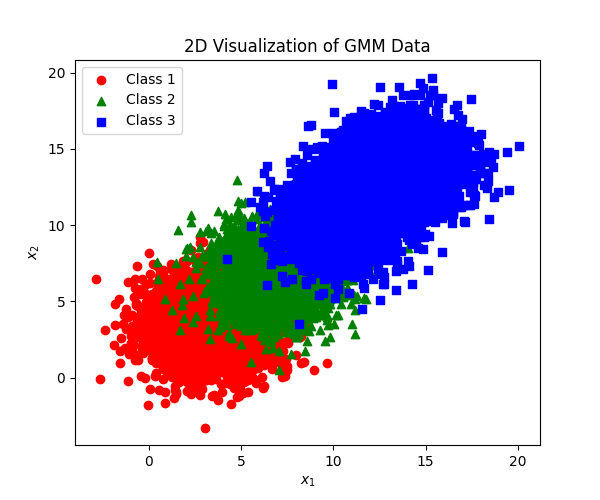

In [4]:
n = 3  # Dimensionality of input vectors
#priors = np.array([0.3, 0.3, 0.2, 0.2])  # Initial priors for four Gaussians

def Gmm(N, gmm_pdf):
    n = gmm_pdf['mu'].shape[1]  # dimensionality of vectors
    X = np.zeros((N, n))
    labels = np.zeros(N, dtype=int)

    # Decide randomly which samples will come from each component
    # Uniform distribution to decide the class based on cumulative prior thresholds
    u = np.random.rand(N)
    thresholds = np.cumsum(gmm_pdf['priors'])
    thresholds = np.insert(thresholds, 0, 0)  # Insert 0 at the start for proper interval comparison

    # Loop over each class to allocate samples
    for i in range(len(gmm_pdf['priors'])):
        # Find indices of samples that fall into the current class interval
        indices = np.where((u > thresholds[i]) & (u <= thresholds[i + 1]))[0]
        if i == 2:  # Special handling for class 3 which is a mixture of two components
            # Half of the indices for one component, half for the other
            half = len(indices) // 2
            first_half = indices[:half]
            second_half = indices[half:]

            # Generate samples from the two sub-components for class 3
            X[first_half, :] = multivariate_normal.rvs(mean=gmm_pdf['mu'][2], cov=gmm_pdf['Cov_matrix'][2], size=len(first_half))
            X[second_half, :] = multivariate_normal.rvs(mean=gmm_pdf['mu'][3], cov=gmm_pdf['Cov_matrix'][3], size=len(second_half))
            labels[indices] = 2  # All get class label 2
        else:
            # Generate samples for this class from its corresponding Gaussian component
            X[indices, :] = multivariate_normal.rvs(mean=gmm_pdf['mu'][i], cov=gmm_pdf['Cov_matrix'][i], size=len(indices))
            labels[indices] = i

    return X, labels

# Standard deviation for the Gaussian components
scale_factor = 3
std_dev = np.sqrt(scale_factor)
desired_distance = 2 * std_dev


priors = np.array([0.3, 0.3, 0.4])  # Adjusted priors to sum to 1
mu =np.array([(i + 1) * desired_distance * np.ones(n) for i in range(4)])
Cov_matrix = np.array([scale_factor * np.eye(n) for _ in range(4)])
# Configuration for the GMM
gmm_pdf = {
    'priors': priors,
    'mu': mu,
    'Cov_matrix': Cov_matrix
}

N = 10000
X, labels = Gmm(N, gmm_pdf)


# Print means and distances
print("Mean vectors (mu):")
print(mu)
print("\nDistances between means:")
for i in range(3):
    for j in range(i+1, 4):
        print(f"Distance between Class {i+1} and Class {j+1}: {np.linalg.norm(mu[i]-mu[j])}")

# Plotting the 3D scatter plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)  # No need for 'projection' argument for 2D

colors = ['r', 'g', 'b']  # Colors for the three classes
markers = ['o', '^', 's']  # Markers for the three classes

# Loop through each class and plot the first two dimensions
for i in range(3):  # Three classes (0, 1, 2)
    ax.scatter(X[labels == i, 0], X[labels == i, 1], color=colors[i], marker=markers[i], label=f'Class {i+1}')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.title('2D Visualization of GMM Data')
plt.legend()
plt.show()

# **Part A: MAP classification**

Total Mumber of Misclassified Samples: 481
Empirically Estimated Probability of Error: 0.0481
Empirical Risk (MAP): 0.04810000000000003


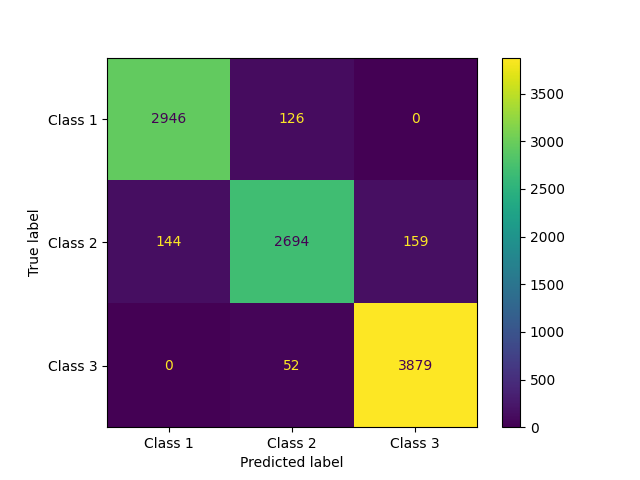

In [5]:
# Implementing the MAP Classifier
def map_classifier(X, priors, mu, Cov_matrix):
    N = X.shape[0]
    C = len(priors)
    posterior_probs = np.zeros((N, C))
    for c in range(C):
        likelihood = multivariate_normal.pdf(X, mean=mu[c], cov=Cov_matrix[c])
        posterior_probs[:, c] = likelihood * priors[c]
    return np.argmax(posterior_probs, axis=1)

classified_labels = map_classifier(X, priors, mu, Cov_matrix)
conf_matrix = confusion_matrix(labels, classified_labels)

correct_class_samples = np.sum(np.diag(conf_matrix))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

# Calculate empirical risk (probability of misclassification)
risk_map = 1 - np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print("Empirical Risk (MAP):", risk_map)

# Display confusion matrix and calculate risk for MAP
conf_display = ConfusionMatrixDisplay(conf_matrix, display_labels=['Class 1', 'Class 2', 'Class 3'])
conf_display.plot()
plt.show()

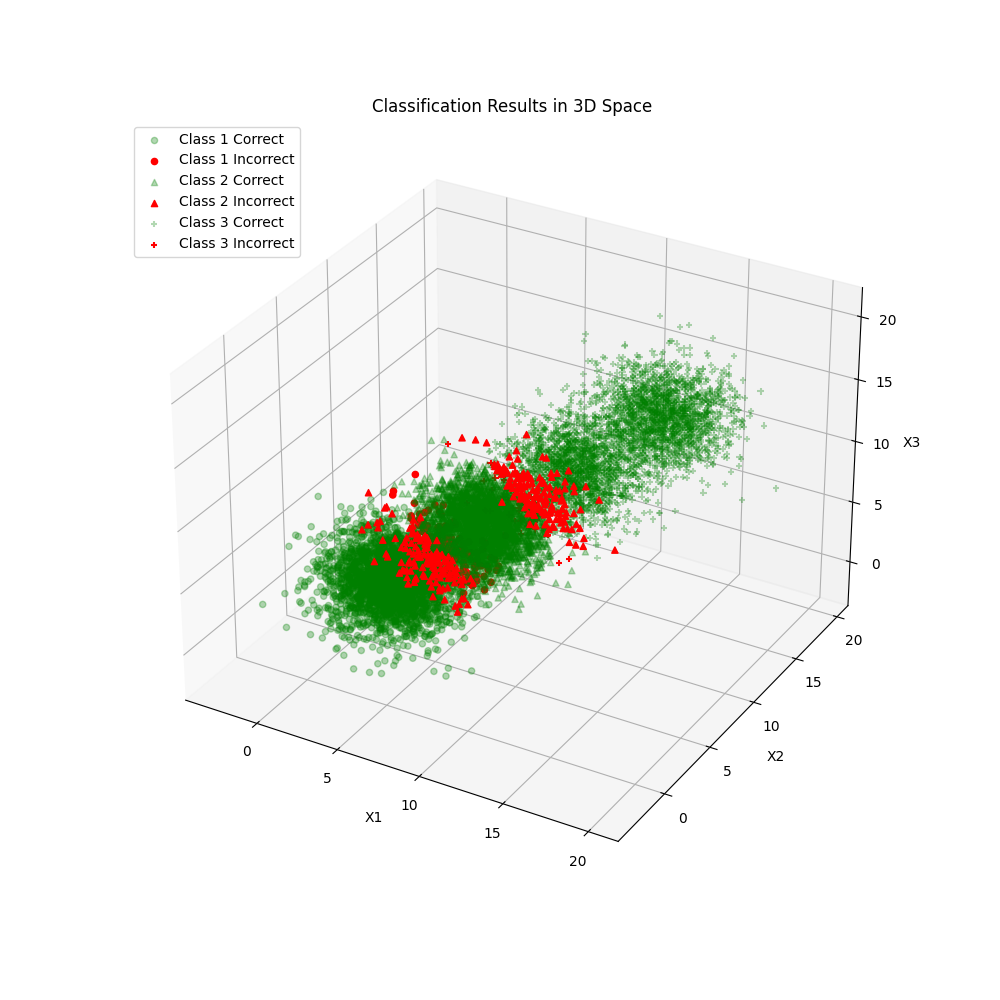

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define marker shapes and colors for each class
markers = ['o', '^', '+']  # Different shapes for each class
colors = ['red', 'blue', 'green']  # Colors assigned to each class

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot each sample
for i in range(len(priors)):
    # Indices for the true class i
    idx = labels == i
    # Indices for correct and incorrect classification
    correct = classified_labels == labels
    incorrect = classified_labels != labels

    # Apply both conditions, correct indexing for true class i and classification correctness
    # Correct classified samples with alpha = 0.5
    ax.scatter(X[(idx) & (correct), 0], X[(idx) & (correct), 1], X[(idx) & (correct), 2],
               c='green', marker=markers[i], label=f'Class {i+1} Correct', alpha=0.3)

    # Incorrect classified samples with alpha = 1
    ax.scatter(X[(idx) & (incorrect), 0], X[(idx) & (incorrect), 1], X[(idx) & (incorrect), 2],
               c='red', marker=markers[i], label=f'Class {i+1} Incorrect', alpha=1)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Classification Results in 3D Space')
ax.legend(loc='upper left')
plt.show()


## **2-D plot of classification**

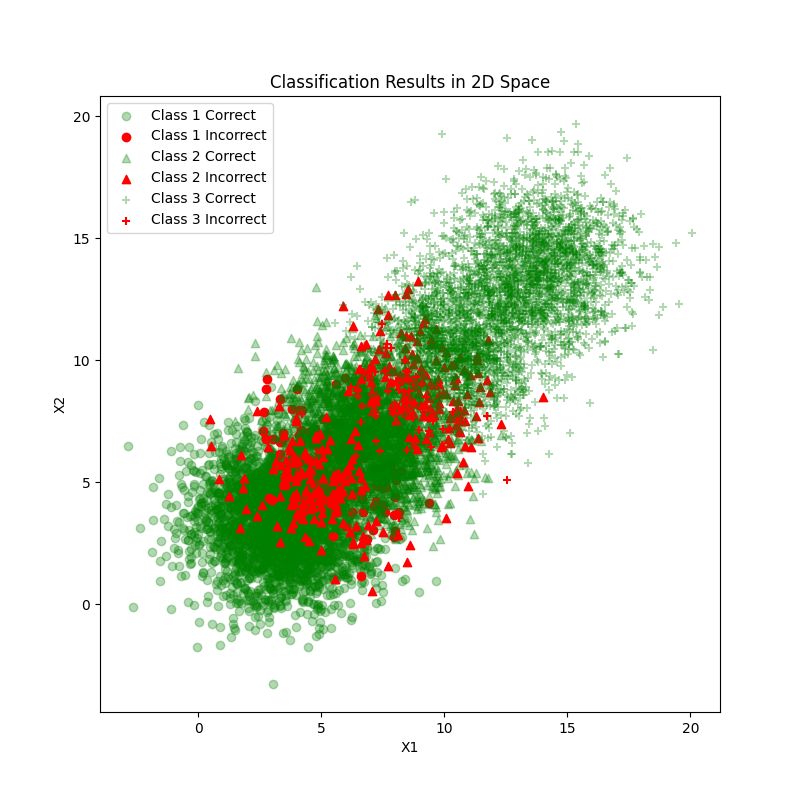

In [11]:
# Define marker shapes and colors for each class
markers = ['o', '^', '+']  # Different shapes for each class
colors = ['red', 'blue', 'green']  # Colors assigned to each class

fig, ax = plt.subplots(figsize=(8, 8))

# Plot each sample
for i in range(len(priors)):
    # Indices for the true class i
    idx = labels == i
    # Indices for correct and incorrect classification
    correct = classified_labels == labels
    incorrect = classified_labels != labels

    # Apply both conditions, correct indexing for true class i and classification correctness
    # Correct classified samples with alpha = 0.5
    ax.scatter(X[(idx) & (correct), 0], X[(idx) & (correct), 1],
               c='green', marker=markers[i], label=f'Class {i+1} Correct', alpha=0.3)

    # Incorrect classified samples with alpha = 1
    ax.scatter(X[(idx) & (incorrect), 0], X[(idx) & (incorrect), 1],
               c='red', marker=markers[i], label=f'Class {i+1} Incorrect', alpha=1)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Classification Results in 2D Space')
ax.legend(loc='upper left')
plt.show()

# **Part B: Implemeting ERM classification (for given Loss functions)**

In [8]:
# Implement ERM with different loss matrices
# Define the loss matrices
Loss_func_10 = np.array([[0, 1, 10],
                      [1, 0, 10],
                      [1, 1, 0]])

Loss_func_100 = np.array([[0, 1, 100],
                       [1, 0, 100],
                       [1, 1, 0]])

def perform_erm_classification(X, Loss_func, priors, mu, Cov_matrix):
    N = X.shape[0]
    risks = np.zeros((N, len(priors)))
    for i in range(len(priors)):
        for j in range(len(priors)):
            likelihood = multivariate_normal.pdf(X, mean=mu[j], cov=Cov_matrix[j])
            risks[:, i] += Loss_func[i, j] * likelihood * priors[j]
    return np.argmin(risks, axis=1)

## **Printing the values for Loss Functions as asked**

Risk for Loss_func_10: 0.5088
Total Mumber of Misclassified Samples: 759
Estimated Probability of Error: 0.0759


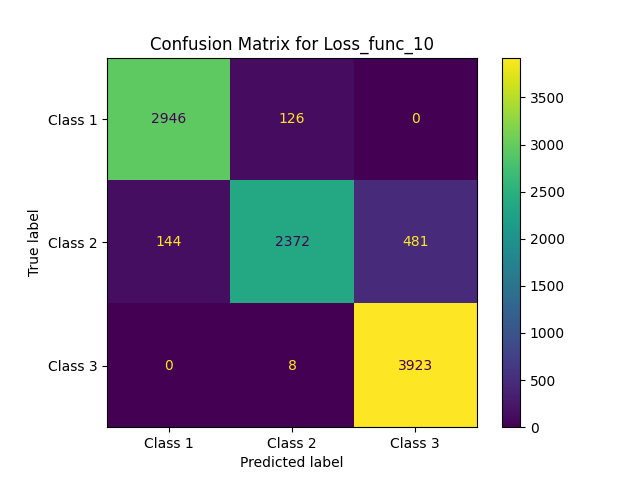

Risk for Loss_func_100: 11.4871
Total Mumber of Misclassified Samples: 1417
Estimated Probability of Error: 0.1417


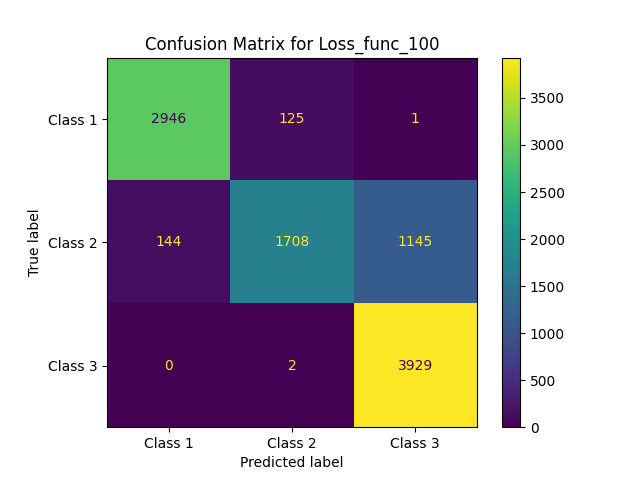

In [9]:
# Classify and calculate risks for each loss matrix
for Loss_func, name in zip([Loss_func_10, Loss_func_100], ['Loss_func_10', 'Loss_func_100']):
    decisions = perform_erm_classification(X, Loss_func, priors, mu, Cov_matrix)
    conf_mat = confusion_matrix(labels, decisions)
    risk_erm = np.sum(np.multiply(conf_mat, Loss_func)) / np.sum(conf_mat)
    print(f"Risk for {name}: {risk_erm}")

    correct_class_samples = np.sum(np.diag(conf_mat))
    print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

    prob_error = 1 - (correct_class_samples / N)
    print("Estimated Probability of Error: {:.4f}".format(prob_error))

    # Visualization of results
    conf_display = ConfusionMatrixDisplay(conf_mat, display_labels=['Class 1', 'Class 2', 'Class 3'])
    conf_display.plot()
    plt.title(f'Confusion Matrix for {name}')
    plt.show()